Checking required packages...
'mask_config.json' not found in current folder.
User chose not to load config.
--> Using Default (No Masking).

Please select the model file (.h5)...
Loading Keras model...
Model loaded successfully!

Please select test images...

Selected 30 images. Processing...



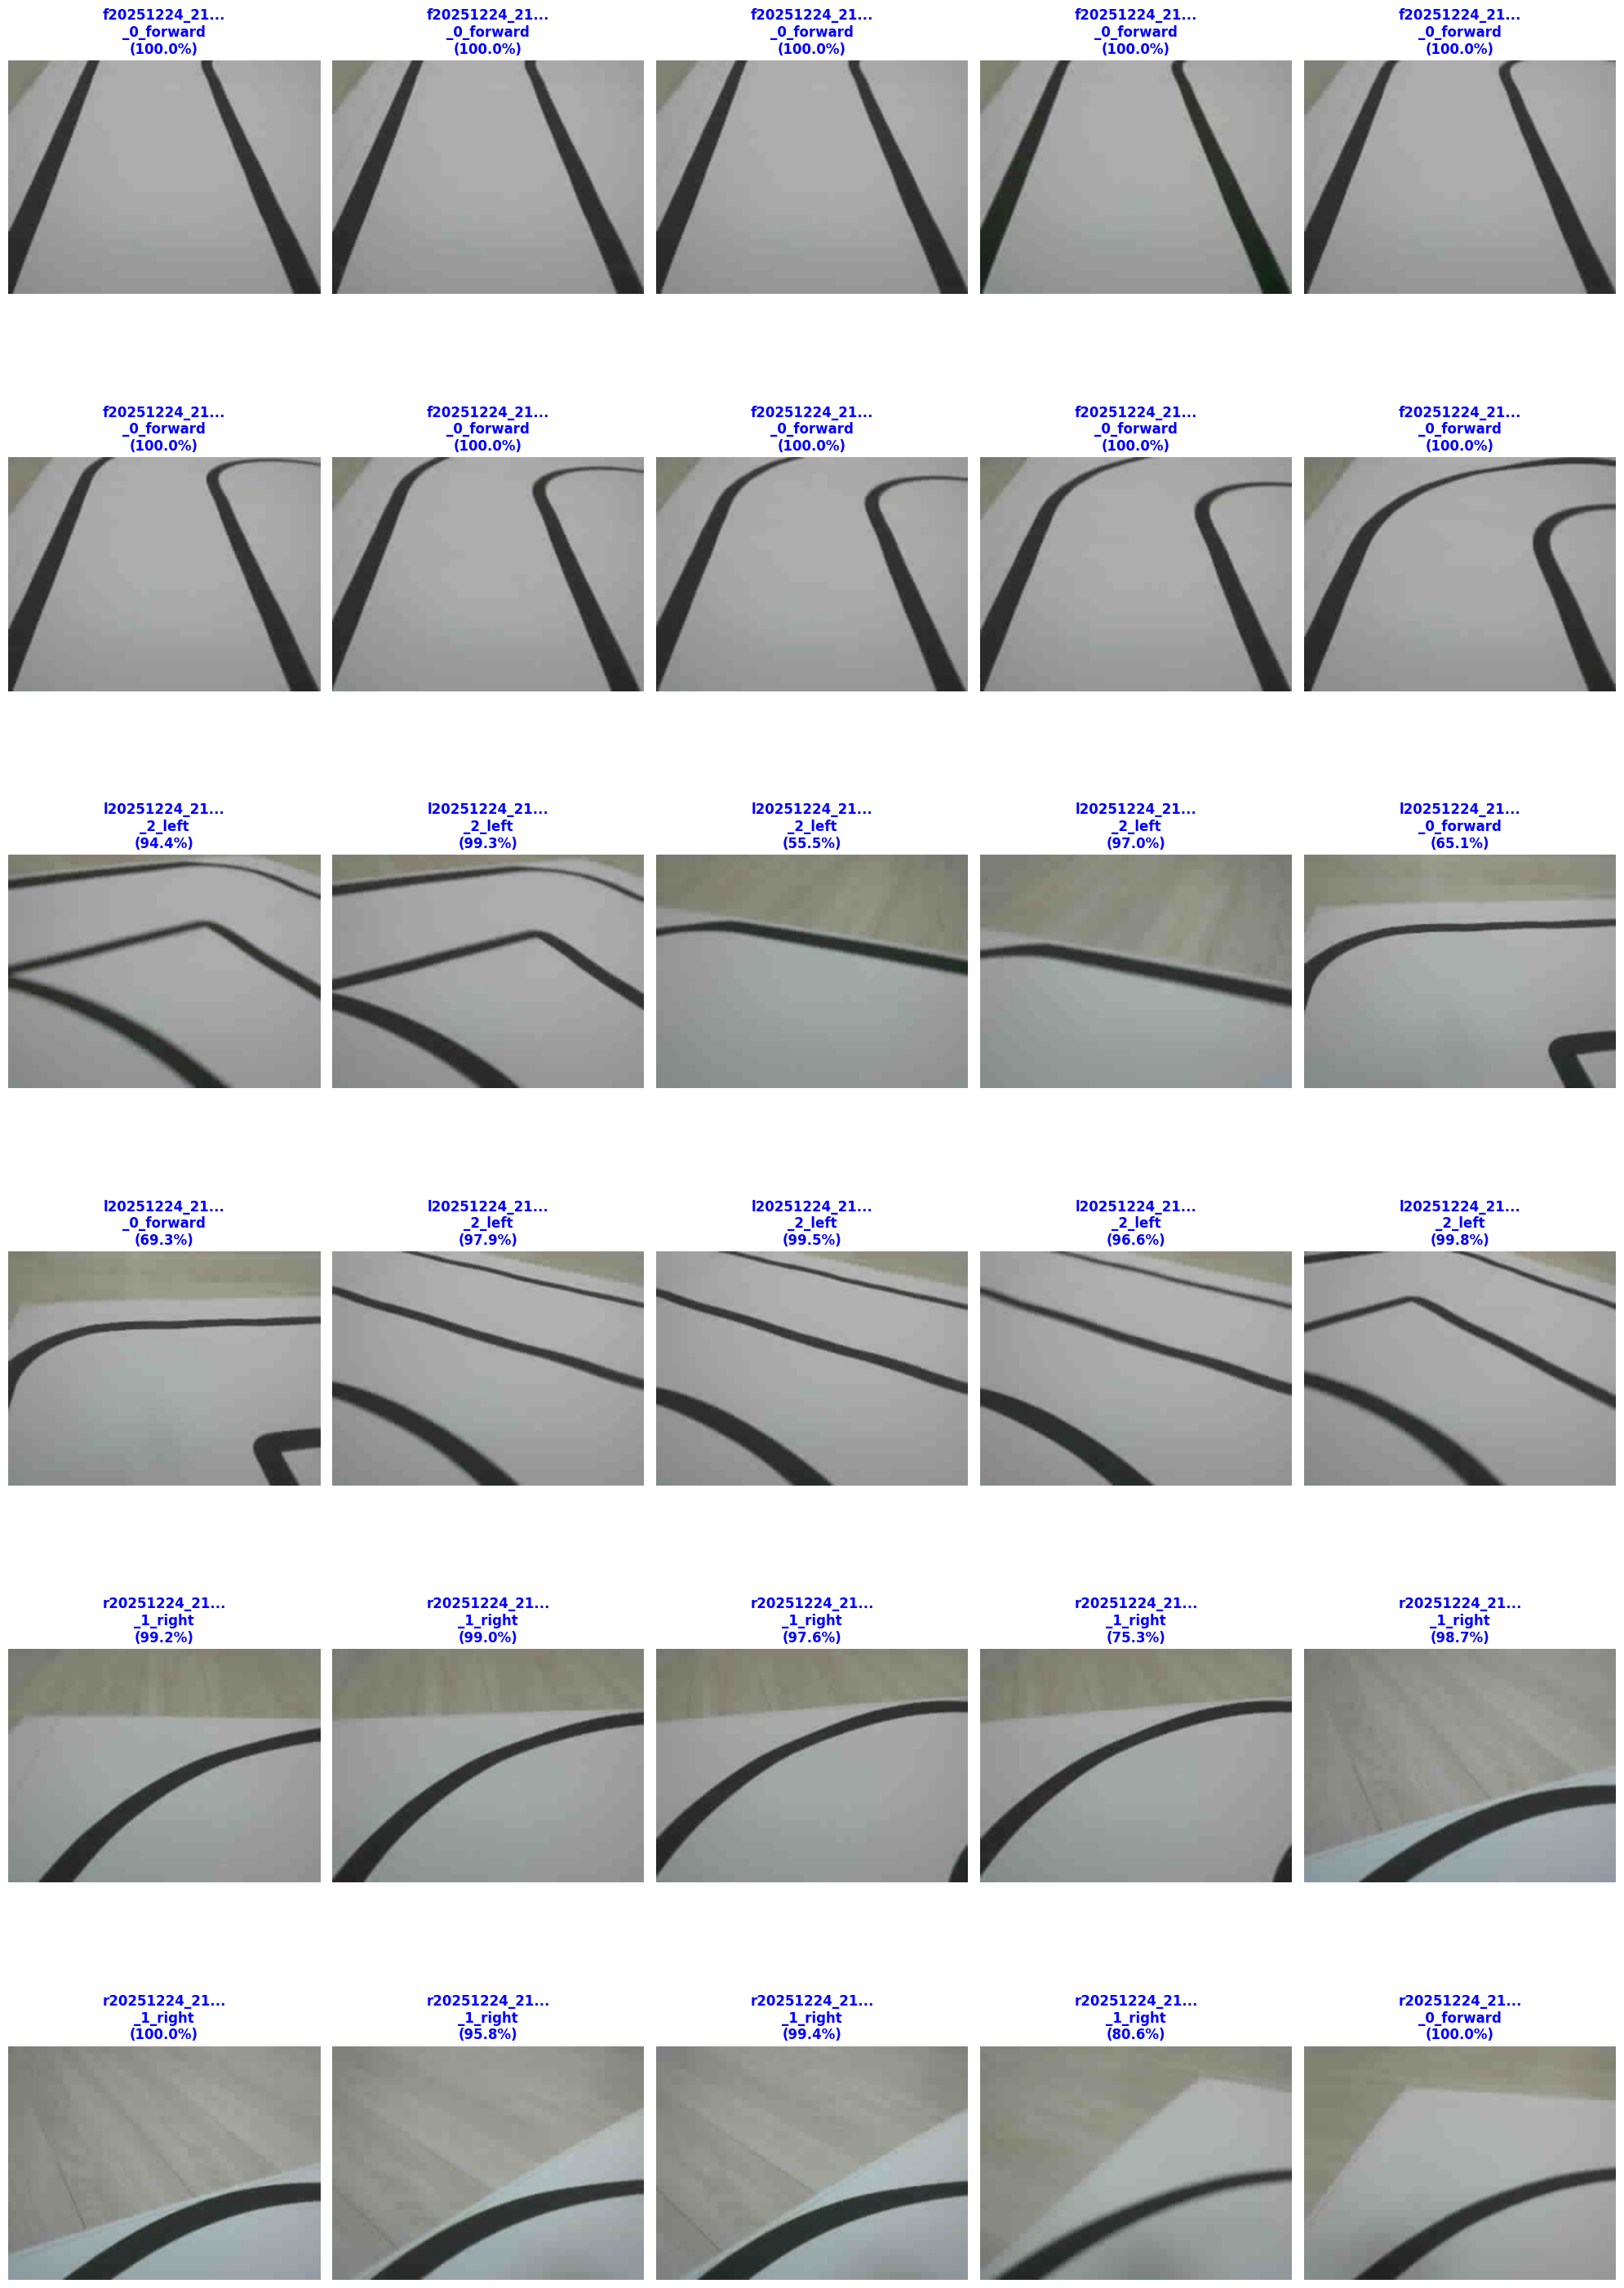

In [14]:
import sys
import subprocess
import importlib
import os
import math
import json
import tkinter as tk
from tkinter import filedialog, messagebox

# ---------------------------------------------------------
# 1. 패키지 자동 설치 함수
# ---------------------------------------------------------
def install_package(module_name, package_name=None):
    if package_name is None:
        package_name = module_name
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {package_name} ...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"{package_name} installation completed")
        except subprocess.CalledProcessError as e:
            print(f"{package_name} installation failed (exit code {e.returncode})")

print("Checking required packages...")
install_package("h5py")
install_package("numpy")
install_package("cv2", "opencv-python")
install_package("PIL", "Pillow")
install_package("tensorflow")
install_package("matplotlib")

import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import load_model

root = tk.Tk()
root.withdraw()

def prepare_dialog():
    """다이얼로그를 띄우기 전, 투명한 메인 윈도우를 최상단에 배치"""
    root.deiconify()              
    root.attributes('-alpha', 0.0)
    root.attributes('-topmost', True)
    root.lift()                   
    root.focus_force()            

def hide_dialog():
    """다이얼로그 종료 후 다시 숨김"""
    root.withdraw()

# ---------------------------------------------------------
# 2. 마스킹 설정 로드
# ---------------------------------------------------------
crop_top, crop_bottom, crop_left, crop_right = 0, 0, 0, 0
config_file_path = "mask_config.json"
load_success = False

if not os.path.exists(config_file_path):
    print(f"'{config_file_path}' not found in current folder.")
    
    prepare_dialog()
    ans = messagebox.askyesno("Config Missing", 
                              "mask_config.json not found.\nDo you want to select a mask config file manually?",
                              parent=root) # parent 지정 필수
    hide_dialog()
    
    if ans:
        prepare_dialog()
        selected_file = filedialog.askopenfilename(
            title="Select Mask Config JSON",
            filetypes=[("JSON Files", "*.json"), ("All Files", "*.*")],
            parent=root
        )
        hide_dialog()
        
        if selected_file:
            config_file_path = selected_file
        else:
            print("File selection cancelled by user.")
            print("--> Using Default (No Masking).")
            config_file_path = None
    else:
        print("User chose not to load config.")
        print("--> Using Default (No Masking).")
        config_file_path = None

if config_file_path and os.path.exists(config_file_path):
    try:
        with open(config_file_path, 'r') as f:
            config = json.load(f)
            crop_top = config.get("top", 0)
            crop_bottom = config.get("bottom", 0)
            crop_left = config.get("left", 0)
            crop_right = config.get("right", 0)
        print(f"--> Loaded mask config from '{os.path.basename(config_file_path)}'")
        print(f"    (Top: {crop_top}, Bottom: {crop_bottom}, Left: {crop_left}, Right: {crop_right})")
        load_success = True
    except Exception as e:
        print(f"Failed to load mask config: {e}")
        prepare_dialog()
        messagebox.showwarning("Warning", f"Failed to parse config file.\nProceeding with no masking.", parent=root)
        hide_dialog()

# ---------------------------------------------------------
# 3. 모델 파일 선택 및 로드
# ---------------------------------------------------------
print("\nPlease select the model file (.h5)...")

prepare_dialog()
model_filename = filedialog.askopenfilename(
    title="Select Teachable Machine Model File",
    filetypes=[("H5 Files", "*.h5"), ("All Files", "*.*")],
    parent=root
)
hide_dialog()

if not model_filename:
    print("No model selected. Exiting...")
    sys.exit()

try:
    # Teachable Machine 모델 호환성 패치
    f = h5py.File(model_filename, mode="r+")
    model_config_string = f.attrs.get("model_config")
    
    if isinstance(model_config_string, bytes):
        model_config_string = model_config_string.decode('utf-8')

    if model_config_string.find('"groups": 1,') != -1:
        print("Patching model config...")
        model_config_string = model_config_string.replace('"groups": 1,', '')
        f.attrs.modify('model_config', model_config_string)
        f.flush()
    f.close()
except Exception as e:
    print(f"Warning during model patch: {e}")

# 모델 로드
print("Loading Keras model...")
try:
    model = load_model(model_filename, compile=False)
    print("Model loaded successfully!")
except Exception as e:
    prepare_dialog()
    messagebox.showerror("Error", f"Failed to load model:\n{e}", parent=root)
    hide_dialog()
    sys.exit()

class_names = ['_0_forward', '_1_right', '_2_left', '_3_stop']

# ---------------------------------------------------------
# 4. 테스트할 이미지 다중 선택
# ---------------------------------------------------------
print("\nPlease select test images...")

prepare_dialog()
file_paths = filedialog.askopenfilenames(
    title="Select Test Images",
    filetypes=[("Images", "*.jpg *.jpeg *.png *.bmp"), ("All Files", "*.*")],
    parent=root
)
hide_dialog()

root.destroy()

if not file_paths:
    print("No images selected. Exiting...")
else:
    print(f"\nSelected {len(file_paths)} images. Processing...\n")
    
    results_images = []
    results_titles = []
    
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    # ---------------------------------------------------------
    # 5. 전처리(마스킹) 및 추론
    # ---------------------------------------------------------
    for img_path in file_paths:
        try:
            # 이미지 로드
            original_image = Image.open(img_path).convert("RGB")
            
            # 640x480 리사이즈
            img_resized = original_image.resize((640, 480))
            img_np = np.array(img_resized)
            
            # 마스킹 적용
            h, w, _ = img_np.shape
            if crop_top > 0: img_np[:crop_top, :] = 0
            if crop_bottom > 0: img_np[h-crop_bottom:, :] = 0
            if crop_left > 0: img_np[:, :crop_left] = 0
            if crop_right > 0: img_np[:, w-crop_right:] = 0
            
            masked_image = Image.fromarray(img_np)

            # AI 모델 입력 전처리
            image_processed = ImageOps.fit(masked_image, (224, 224), Image.Resampling.LANCZOS)
            image_array = np.asarray(image_processed)
            normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1.0
            data[0] = normalized_image_array

            # 추론
            prediction = model.predict(data, verbose=0)
            idx = np.argmax(prediction)
            confidence = prediction[0][idx] * 100 
            
            file_name = os.path.basename(img_path)
            if len(file_name) > 15: file_name = file_name[:12] + "..."
            
            title_text = f"{file_name}\n{class_names[idx]}\n({confidence:.1f}%)"
            
            results_images.append(masked_image)
            results_titles.append(title_text)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # ---------------------------------------------------------
    # 6. 결과 출력
    # ---------------------------------------------------------
    total_images = len(results_images)
    if total_images > 0:
        cols = 5 
        rows = math.ceil(total_images / cols) 

        plt.figure(figsize=(20, 5 * rows)) 

        for i in range(total_images):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(results_images[i])
            plt.title(results_titles[i], fontsize=12, fontweight='bold', color='blue')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No images processed successfully.")